## Headers

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"GPU Name: {details['device_name']}")
else:
    print("No GPUs found.")

No GPUs found.


In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

warnings.filterwarnings('ignore')

## EDA Images

In [4]:
image_path = "Images"
data = pd.read_csv("captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [5]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"{image_path}/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

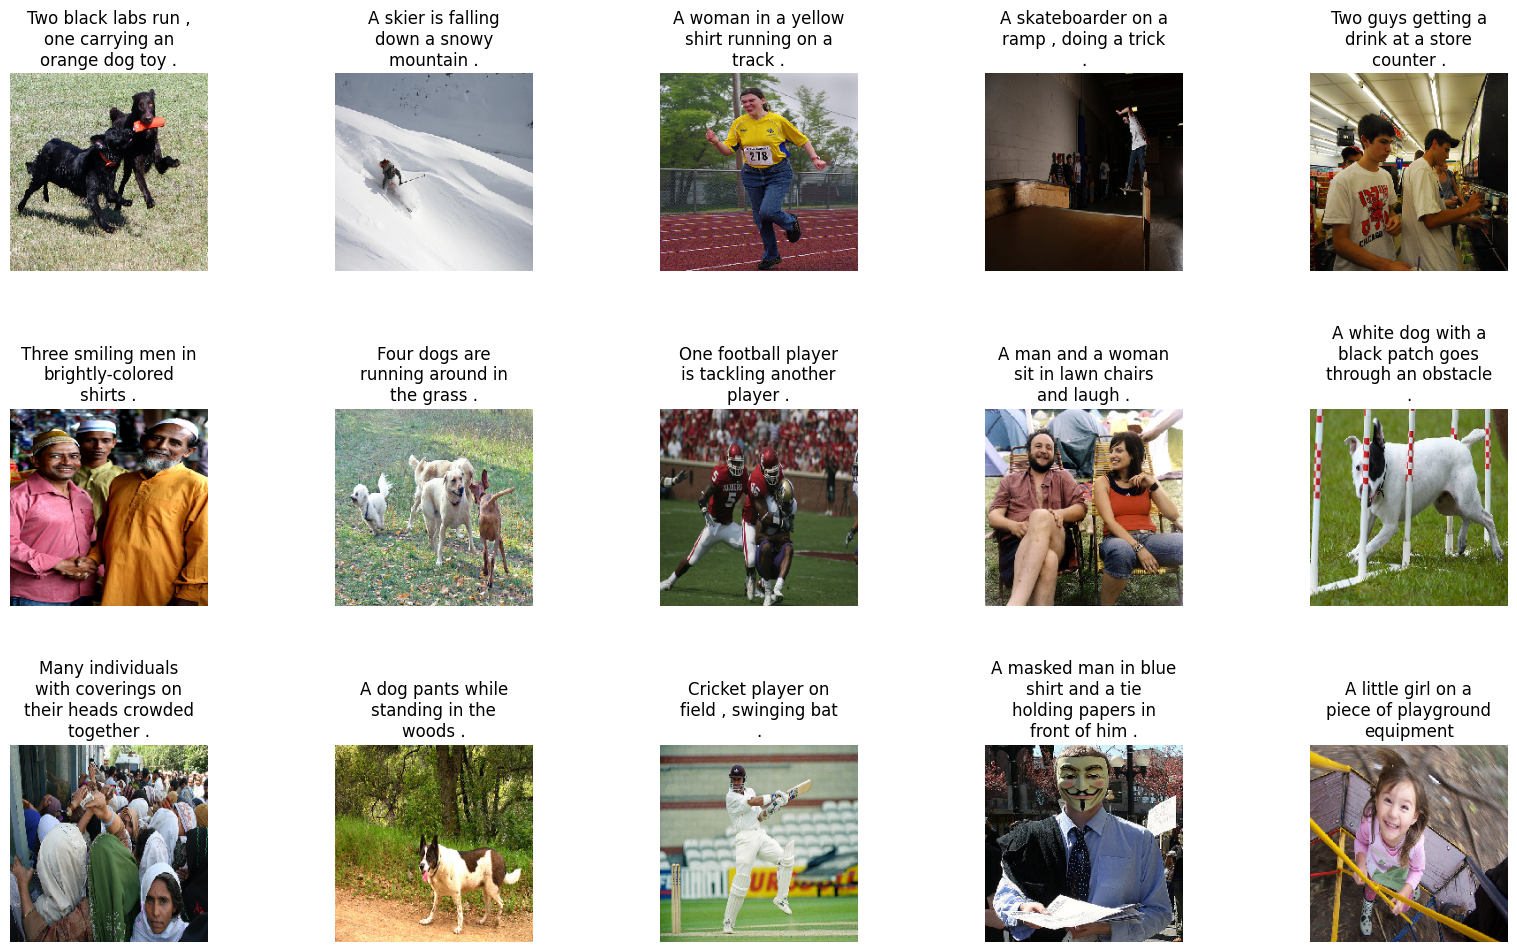

In [6]:
display_images(data.sample(15))

In [7]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [8]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

## BaseLine Model

In [10]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [10:54<00:00, 12.37it/s]


In [11]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [12]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [13]:
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,172,160 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 35, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8485)      │  1,094,565 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [15]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=20, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [16]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)


Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 5.6937
Epoch 1: val_loss improved from inf to 4.27283, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 177s 328ms/step - loss: 5.6926 - val_loss: 4.2728 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - loss: 4.3264
Epoch 2: val_loss improved from 4.27283 to 3.97236, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 218s 405ms/step - loss: 4.3263 - val_loss: 3.9724 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - loss: 4.0224
Epoch 3: val_loss improved from 3.97236 to 3.81832, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 220s 410ms/step - loss: 4.0223 - val_loss: 3.8183 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - loss: 3.8378
Epoch 4: val_loss improved from 3.81832 to 3.73575, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 224s 418ms/step - loss: 3.8378 - val_loss: 3.7357 - learning_rate: 0.0

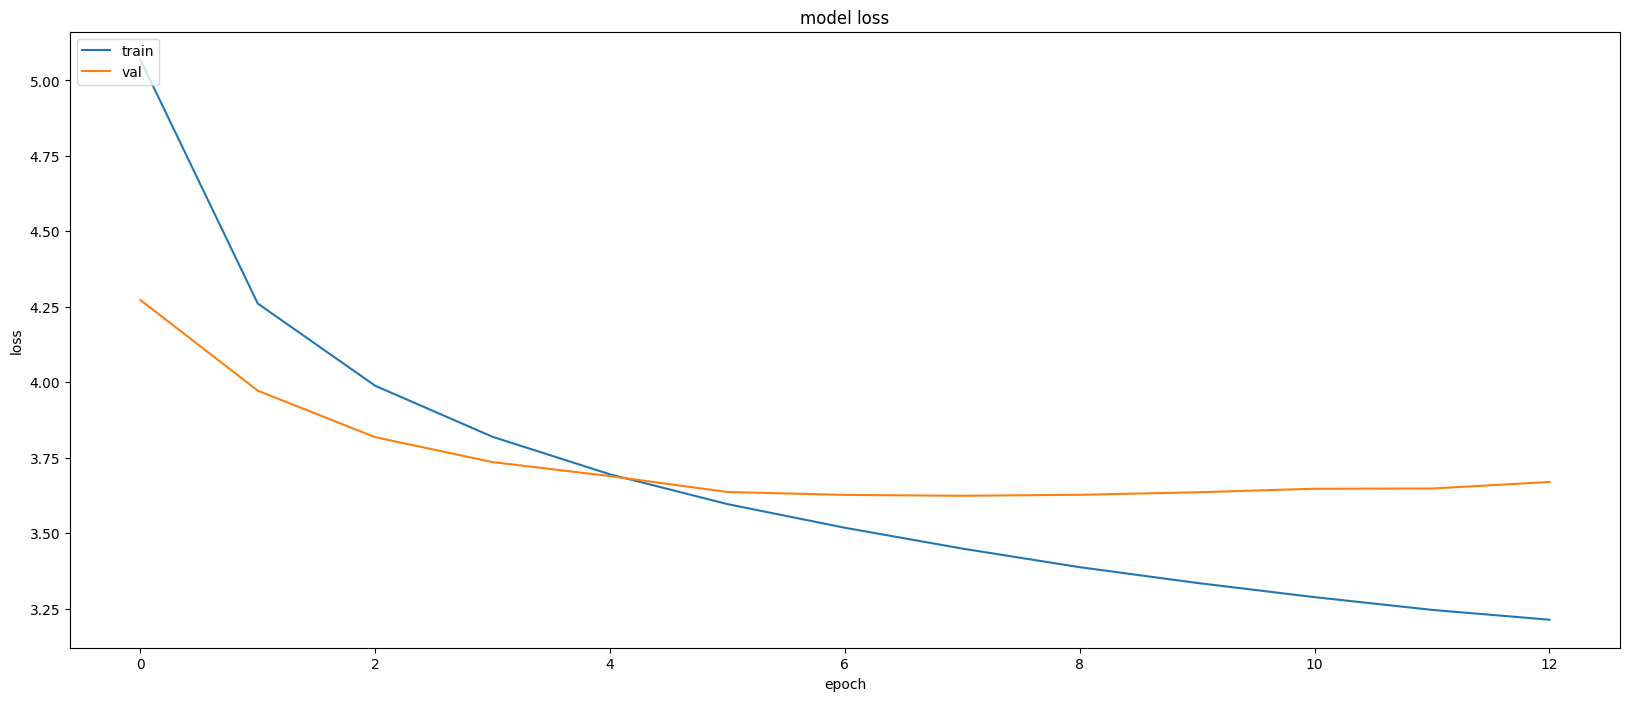

In [17]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## YOLO Model

In [ ]:
# Clone YOLOv5 and install requirements
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt
%cd ..

In [14]:
# ✅ Load YOLOv5s model directly from Ultralytics
import torch

# This will auto-download weights & config
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# ✅ Function to detect objects
def detect_objects_yolo(image_path):
    """
    Detects objects using YOLOv5 in a given image and returns a list of object labels.
    """
    results = yolo_model(image_path)  # Run inference
    labels = results.names  # Label dictionary
    detections = results.pred[0]  # Get first image's predictions

    if detections is None or len(detections) == 0:
        return []

    class_ids = detections[:, -1].tolist()  # Get class ID
    return list(set([labels[int(idx)] for idx in class_ids]))  # Unique detected classes

Using cache found in /Users/vedclove/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-23 Python-3.11.11 torch-2.7.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [15]:
sample_img = os.path.join(image_path, test.iloc[0]["image"])
objects = detect_objects_yolo(sample_img)
print("Detected objects:", objects)

Detected objects: ['cup', 'person', 'bottle', 'chair']


In [16]:
def filter_hallucinated_caption(caption, detected_objects):
    """
    Filters words in the caption that do not match detected objects.
    Keeps words that are either stopwords or detected object names.
    """
    from nltk.corpus import stopwords
    import nltk
    nltk.download("stopwords")
    
    stop_words = set(stopwords.words("english"))
    words = caption.split()
    filtered = []

    for word in words:
        word_clean = word.lower().strip(".,")
        if word_clean in detected_objects or word_clean in stop_words:
            filtered.append(word)

    return " ".join(filtered)

In [19]:
# Pick a sample image from test set
sample_row = test.sample(1).iloc[0]
image_name = sample_row["image"]
image_path_sample = os.path.join(image_path, image_name)

# Generate caption
caption = predict_caption(caption_model, image_name, tokenizer, max_length, features)

# Run detection + filtering
detected = detect_objects_yolo(image_path_sample)
filtered_caption = filter_hallucinated_caption(caption, detected)

print("\n🖼 Image:", image_name)
print("\n📌 Detected Objects:", detected)
print("\n✏️ Original Caption:", caption)
print("\n✅ Filtered Caption:", filtered_caption)


🖼 Image: 804087017_330bcc8c56.jpg

📌 Detected Objects: ['person', 'umbrella', 'traffic light', 'bench']

✏️ Original Caption: unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused unamused

✅ Filtered Caption: 


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vedclove/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length, features):
    feature = features[image]
    in_text = "startseq"
    
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None or word == "endseq":
            break
        in_text += " " + word
    return in_text.replace("startseq", "").strip()


In [20]:
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vedclove/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vedclove/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vedclove/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vedclove/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vedclove/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


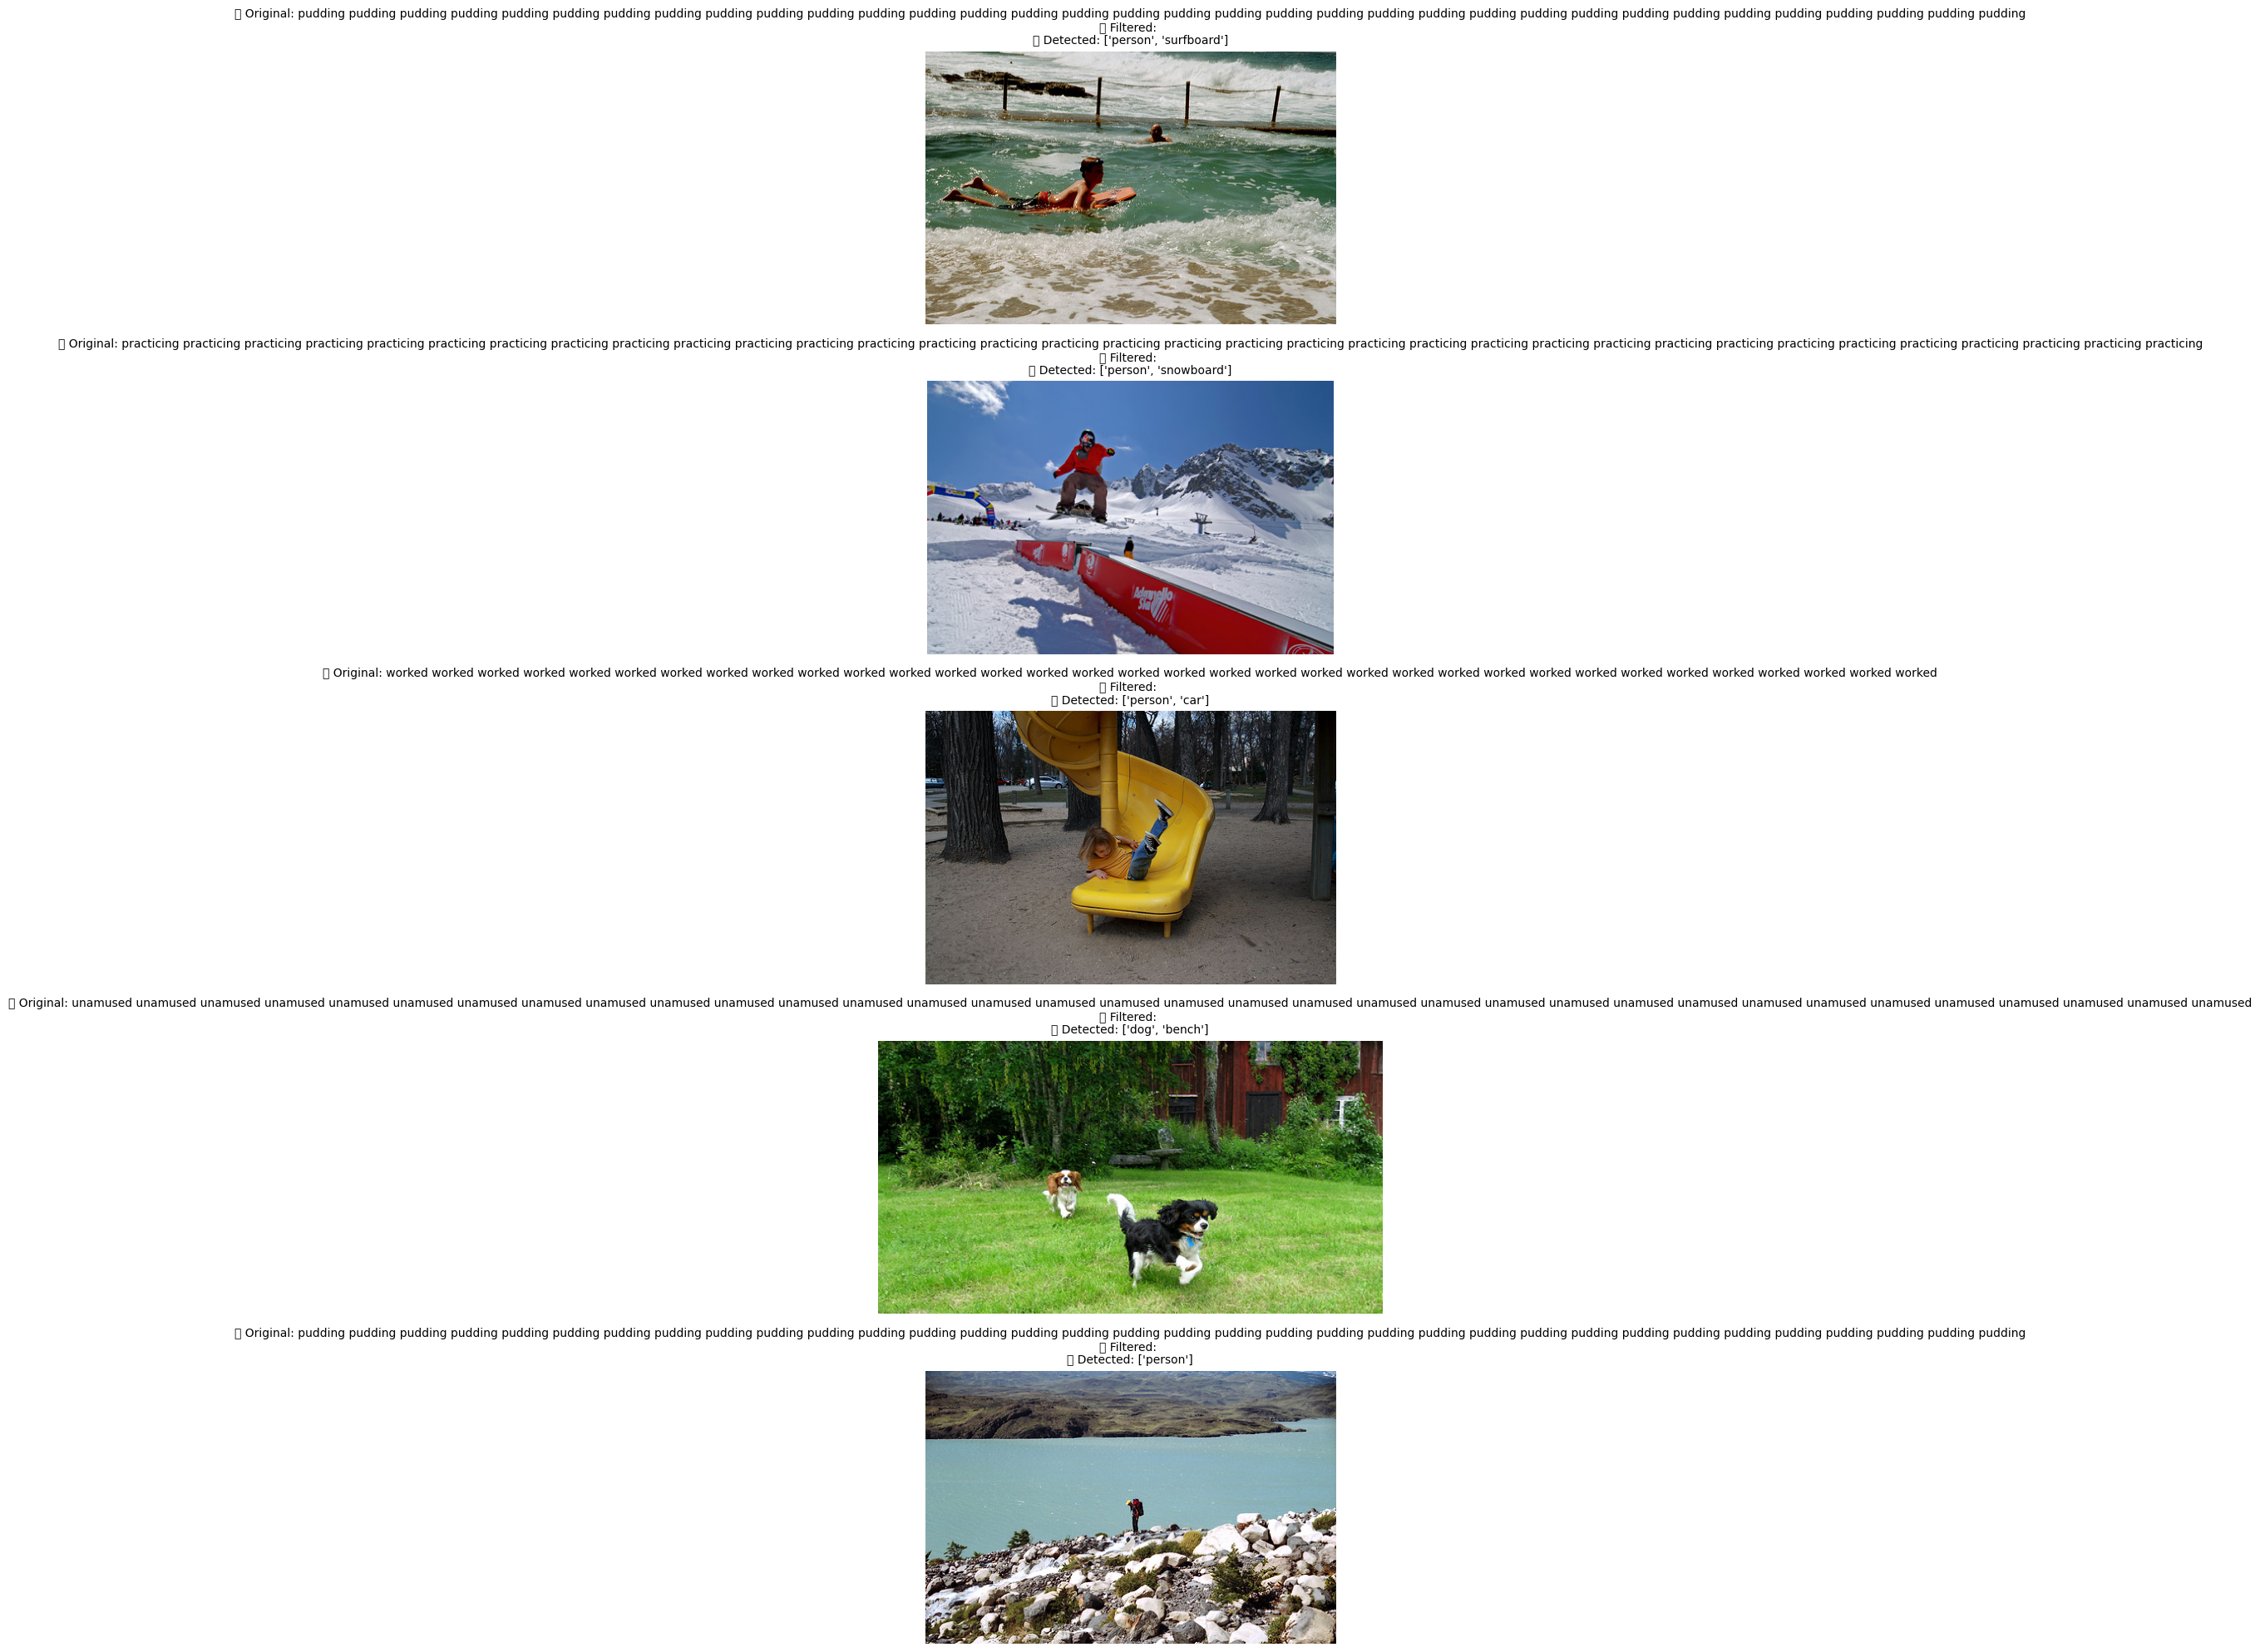

In [21]:
import matplotlib.pyplot as plt
from PIL import Image

# Sample 5 images from the test set
sampled_rows = test.sample(5).reset_index(drop=True)

# Store results
results = []

for idx, row in sampled_rows.iterrows():
    image_name = row['image']
    image_path_full = os.path.join(image_path, image_name)

    # Original caption from your model
    original_caption = predict_caption(caption_model, image_name, tokenizer, max_length, features)

    # Object detection using YOLO
    detected_objects = detect_objects_yolo(image_path_full)

    # Filter hallucinations
    filtered_caption = filter_hallucinated_caption(original_caption, detected_objects)

    # Save result
    results.append({
        "image_path": image_path_full,
        "original_caption": original_caption,
        "filtered_caption": filtered_caption,
        "detected": detected_objects
    })

# 🔍 Visualization
fig, axes = plt.subplots(nrows=5, figsize=(14, 20))

for i, result in enumerate(results):
    image = Image.open(result["image_path"])
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(
        f"📝 Original: {result['original_caption']}\n✅ Filtered: {result['filtered_caption']}\n📌 Detected: {result['detected']}",
        fontsize=10
    )

plt.tight_layout()
plt.show()



In [22]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/vedclove/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer

# Manually train a basic tokenizer if needed
trainer = PunktTrainer()
trainer.INCLUDE_ALL_COLLOCS = True
trainer.train("This is a sentence. Here's another one!")

# Apply the trained tokenizer to avoid the punkt_tab error
tokenizer = PunktSentenceTokenizer(trainer.get_params())
tokens = tokenizer.tokenize("This is a test. Just to make sure it works.")

print(tokens)


['This is a test.', 'Just to make sure it works.']


In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)  # captions is your training corpus


In [25]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /Users/vedclove/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

def compute_bleu_scores(references, hypotheses):
    smooth_fn = SmoothingFunction().method1
    bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smooth_fn)
    bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn)
    return {"BLEU-1": bleu_1, "BLEU-2": bleu_2}

# Prepare references and predictions
original_hyps = []
filtered_hyps = []
references = []

sampled_test = test.sample(50).reset_index(drop=True)  # Use 50 samples to save time

for idx, row in sampled_test.iterrows():
    image_name = row["image"]
    ref_caption = row["caption"]
    
    # Predict caption (original)
    orig_caption = predict_caption(caption_model, image_name, tokenizer, max_length, features)
    
    # Detect objects and filter
    detected_objects = detect_objects_yolo(os.path.join(image_path, image_name))
    filtered_caption = filter_hallucinated_caption(orig_caption, detected_objects)

    # Append all
    references.append([word_tokenize(ref_caption)])
    original_hyps.append(word_tokenize(orig_caption))
    filtered_hyps.append(word_tokenize(filtered_caption))

# Compute BLEU scores
original_scores = compute_bleu_scores(references, original_hyps)
filtered_scores = compute_bleu_scores(references, filtered_hyps)

# Print comparison
print("\n🔍 BLEU Score Comparison:")
print("Before Filtering:", original_scores)
print("After Filtering:", filtered_scores)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vedclove/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/vedclove/nltk_data'
    - '/opt/anaconda3/envs/imgcap/nltk_data'
    - '/opt/anaconda3/envs/imgcap/share/nltk_data'
    - '/opt/anaconda3/envs/imgcap/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


**RUN TILL ABOVE**

In [27]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

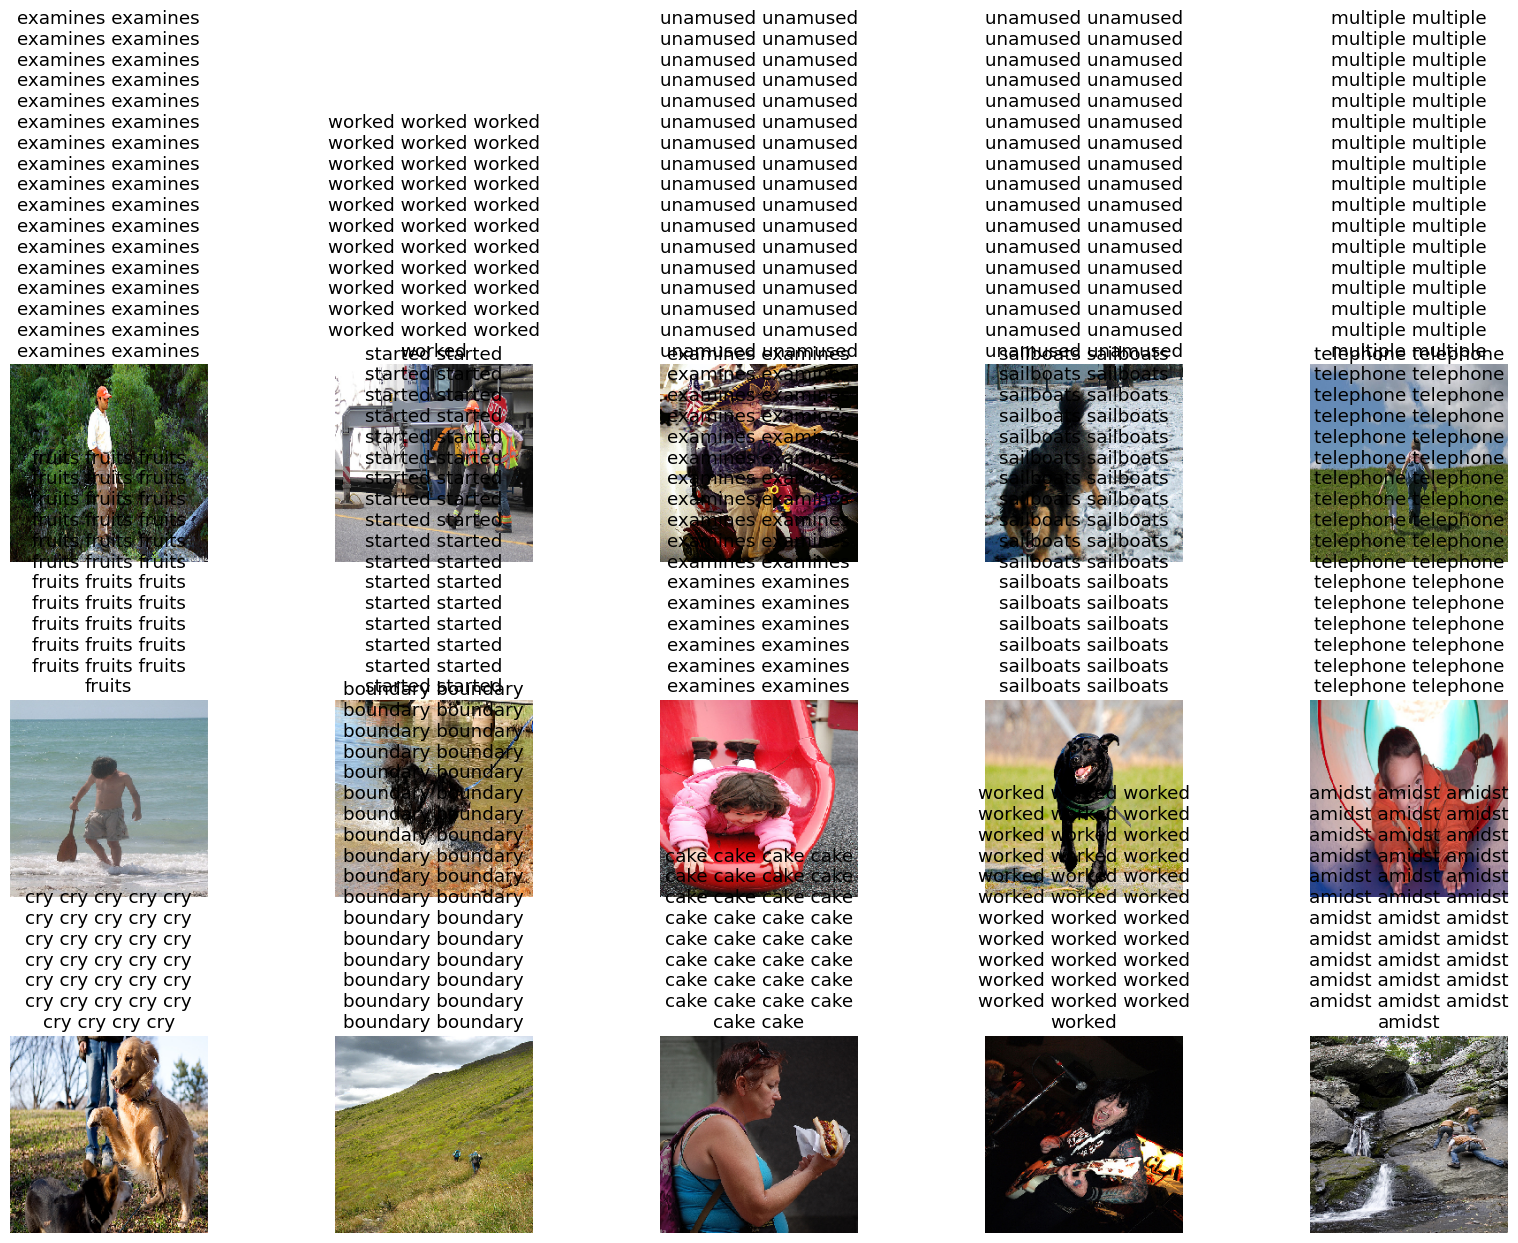

In [28]:
display_images(samples)

In [12]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

def __get_data(self, batch):
    X1, X2, y = list(), list(), list()

    images = batch[self.X_col].tolist()

    for image in images:
        feature = self.features[image][0]  # CNN features
        
        captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
        for caption in captions:
            seq = self.tokenizer.texts_to_sequences([caption])[0]

            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size, dtype=np.float32)[0]

                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)

    # ✅ Ensure Correct Data Types
    X1 = np.array(X1, dtype=np.float32)  # Image features
    X2 = np.array(X2, dtype=np.int32)  # Caption sequences
    y = np.asarray(y, dtype=np.float32)  # Ensures `y` is float32 at the last step
 # ✅ Correct type for TensorFlow
  # One-hot encoded labels

    return X1, X2, y

In [13]:
(sample_X1, sample_X2), sample_y = train_generator[0]

print("📌 Sample Image Feature Shape:", sample_X1.shape, "Type:", sample_X1.dtype)
print("📌 Sample Caption Input Shape:", sample_X2.shape, "Type:", sample_X2.dtype)
print("📌 Sample Output Shape:", sample_y.shape, "Type:", sample_y.dtype)


📌 Sample Image Feature Shape: (3543, 1920) Type: float32
📌 Sample Caption Input Shape: (3543, 34) Type: int32
📌 Sample Output Shape: (3543, 8485) Type: float64


In [14]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [15]:
history = caption_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)


Epoch 1/10


TypeError: Exception encountered when calling BroadcastTo.call().

[1mFailed to convert elements of (None, 34, 512) to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.[0m

Arguments received by BroadcastTo.call():
  • x=tf.Tensor(shape=(None, 34, 1), dtype=bool)

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text

In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

In [ ]:
display_images(samples)

In [ ]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
    
with open("features.pkl", "wb") as f:
    pickle.dump(features, f)
    
caption_model.save("caption_model.h5")

In [ ]:
!pip install tf2onnx

In [ ]:
import os

# Check if the model file exists
model_path = "/kaggle/working/caption_model.h5"

if os.path.exists(model_path):
    print("\n✅ Model file found!")
else:
    print("\n❌ Model file not found. Ensure it is saved before loading.")


In [ ]:
import tf2onnx

# Convert the model to ONNX format
model_proto, _ = tf2onnx.convert.from_keras(caption_model, opset=13)

# Save the ONNX model
onnx_model_path = "/kaggle/working/caption_model.onnx"
with open(onnx_model_path, "wb") as f:
    f.write(model_proto.SerializeToString())

print("\n✅ Model successfully saved in ONNX format as", onnx_model_path)


In [ ]:
import tf2onnx
import tensorflow as tf

caption_model = tf.keras.models.load_model("caption_model.h5")

onnx_model_path = "caption_model.onnx"
spec = (tf.TensorSpec((None, 1920), tf.float32), tf.TensorSpec((None, max_length), tf.float32))
model_proto, _ = tf2onnx.convert.from_keras(caption_model, input_signature=spec, opset=13)

with open(onnx_model_path, "wb") as f:
    f.write(model_proto.SerializeToString())

print("Model saved in ONNX format as", onnx_model_path)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"GPU Name: {details['device_name']}")
else:
    print("No GPUs found.")

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

warnings.filterwarnings('ignore')

In [ ]:
image_path = "/kaggle/input/flickr8k/Images"
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head()

In [ ]:
def read_image(image_name, image_dir=image_path, img_size=224):
    """
    Load and preprocess an image.
    
    Parameters:
    - image_name: Name of the image file.
    - image_dir: Directory containing the images.
    - img_size: Target size for the image.
    
    Returns:
    - Processed image as an array.
    """
    path = os.path.join(image_dir, image_name)
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    return img

def display_images(temp_df, image_dir=image_path, num_images=15, rows=5, cols=5):
    """
    Display randomly selected unique images with their captions.
    
    Parameters:
    - temp_df: DataFrame containing image names and captions.
    - image_dir: Directory where images are stored.
    - num_images: Number of images to display.
    - rows: Number of rows in the grid.
    - cols: Number of columns in the grid.
    """
    temp_df = temp_df.sample(n=num_images, random_state=42).reset_index(drop=True)  # Randomly select unique images

    plt.figure(figsize=(20, 20))
    
    for i, (image_name, caption) in enumerate(zip(temp_df['image'], temp_df['caption'])):
        plt.subplot(rows, cols, i + 1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        
        image = read_image(image_name, image_dir)
        plt.imshow(image)
        plt.title("\n".join(wrap(caption, 20)))
        plt.axis("off")
    
    plt.show()


In [ ]:
# Display 15 unique images
display_images(data)

In [ ]:
import pandas as pd

# Dataset path
caption_file = "/kaggle/input/flickr8k/captions.txt"

# Load the dataset
data = pd.read_csv(caption_file)

# Create a copy of the dataset to store preprocessed captions
cleaned_data = data.copy()

# Display original captions (before preprocessing)
print("Before Preprocessing:")
print(data.head())


In [ ]:
# Convert all captions to lowercase
cleaned_data["caption"] = cleaned_data["caption"].str.lower()

# Show first few rows after lowercasing
print("\nAfter Lowercasing:")
print(cleaned_data.head())


In [ ]:
import re
import string

def remove_special_chars(text):
    """
    Removes punctuation, numbers, and extra spaces.
    """
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Apply function to captions
cleaned_data["caption"] = cleaned_data["caption"].apply(remove_special_chars)

# Show first few rows after cleaning special characters
print("\nAfter Removing Special Characters & Numbers:")
print(cleaned_data.head())


In [ ]:
def filter_short_words(text, min_length=2):
    """
    Removes words with length less than min_length.
    """
    words = text.split()
    words = [word for word in words if len(word) >= min_length]
    return " ".join(words)

# Apply short word filtering
cleaned_data["caption"] = cleaned_data["caption"].apply(filter_short_words)

# Show first few rows after filtering short words
print("\nAfter Filtering Short Words:")
print(cleaned_data.head())


In [ ]:
import spacy

# Load English NLP model
nlp = spacy.load("en_core_web_sm")

def lemmatize_caption(text):
    """
    Converts words to their root form using spaCy's lemmatizer.
    """
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    return " ".join(lemmatized_words)

# Apply lemmatization to a new DataFrame (DO NOT modify original `data`)
cleaned_data = data.copy()
cleaned_data["caption"] = cleaned_data["caption"].apply(lemmatize_caption)

# Show first few rows after lemmatization
print("\nAfter Lemmatization:")
print(cleaned_data.head())

In [ ]:
# Manually define common stopwords
custom_stopwords = set(["a", "an", "and", "is", "in", "it", "of", "on", "the", "to", "with"])

def remove_stopwords(text):
    """
    Removes stopwords from captions.
    """
    words = text.split()
    words = [word for word in words if word not in custom_stopwords]
    return " ".join(words)

# Apply stopword removal
cleaned_data["caption"] = cleaned_data["caption"].apply(remove_stopwords)

# Show first few rows after removing stopwords
print("\nAfter Removing Stopwords:")
print(cleaned_data.head())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count words per caption
cleaned_data["word_count"] = cleaned_data["caption"].apply(lambda x: len(str(x).split()))

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(cleaned_data["word_count"], bins=20, kde=True)
plt.title("Distribution of Caption Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


In [ ]:
from collections import Counter

# Flatten all words in captions
all_words = " ".join(cleaned_data['caption']).split()
word_counts = Counter(all_words)

# Show top 100 most common words
print("\nTop 100 Most Common Words:")
print(word_counts.most_common(100))

In [ ]:
from wordcloud import WordCloud

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))

# Display Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Common Words")
plt.show()


In [ ]:
unique_words = set(all_words)
print(f"\nTotal Unique Words in Cleaned Captions: {len(unique_words)}")

In [ ]:
import random
from tensorflow.keras.preprocessing.image import load_img
from textwrap import wrap

# Select a random image
random_image = random.choice(cleaned_data["image"].unique())
img_path = f"/kaggle/input/flickr8k/Images/{random_image}"

# Get all captions for this image
captions_list = cleaned_data[cleaned_data["image"] == random_image]["caption"].tolist()

# Display Image
plt.figure(figsize=(6, 6))
img = load_img(img_path)
plt.imshow(img)
plt.axis("off")
plt.title(f"Captions for {random_image}:\n" + "\n".join(wrap(captions_list[0], 30)))  # Show first caption
plt.show()

In [ ]:
cleaned_data["unique_word_count"] = cleaned_data["caption"].apply(lambda x: len(set(x.split())))

plt.figure(figsize=(8, 5))
sns.scatterplot(x=cleaned_data["word_count"], y=cleaned_data["unique_word_count"], alpha=0.5)
plt.title("Unique Words vs. Total Words in Captions")
plt.xlabel("Total Words in Caption")
plt.ylabel("Unique Words")
plt.show()


In [ ]:
## REMOVING DUPICATE IMAGES

In [ ]:
# Count total images and unique images
total_images = cleaned_data["image"].count()
unique_images = cleaned_data["image"].nunique()
duplicate_images = total_images - unique_images  # Number of duplicate image entries

# Print results
print(f"Total Images: {total_images}")
print(f"Unique Images: {unique_images}")
print(f"Duplicate Image Entries: {duplicate_images}")


In [ ]:
# Drop duplicate images while keeping the first occurrence
filtered_data = cleaned_data.drop_duplicates(subset=["image"], keep="first").reset_index(drop=True)

# Confirm number of unique images after removing duplicates
print(f"\nTotal Unique Images After Removing Duplicates: {filtered_data['image'].nunique()}")

In [ ]:
filtered_data.count()

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Extract all cleaned captions
all_captions = cleaned_data["caption"].tolist()

# Initialize Tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")  # Handles out-of-vocabulary words
tokenizer.fit_on_texts(all_captions)

# Convert text to sequences (each word → number)
sequences = tokenizer.texts_to_sequences(all_captions)

# View sample mapping
print("\nSample Tokenized Captions:")
for i, caption in enumerate(all_captions[:5]):
    print(f"Original: {caption}")
    print(f"Tokenized: {sequences[i]}\n")


In [ ]:
# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # +1 because index starts from 1

print(f"\nVocabulary Size: {vocab_size}")


In [ ]:
# Get the maximum length of any caption
max_caption_length = max(len(seq) for seq in sequences)

print(f"\nMax Caption Length: {max_caption_length}")

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad sequences to max_caption_length
padded_sequences = pad_sequences(sequences, maxlen=max_caption_length, padding="post")

# View example
print("\nSample Padded Captions:")
for i in range(3):
    print(padded_sequences[i])

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Convert to NumPy arrays for TensorFlow
padded_sequences = np.array(padded_sequences)
image_filenames = np.array(cleaned_data["image"])

# Split data (85% train, 15% validation)
train_images, val_images, train_captions, val_captions = train_test_split(
    image_filenames, padded_sequences, test_size=0.15, random_state=42
)

# Print split details
print(f"\nTraining Images: {len(train_images)}")
print(f"Validation Images: {len(val_images)}")


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

# Load InceptionV3 without weights & without the top classification layer
base_model = InceptionV3(weights=None, include_top=False)

# Print all layer names to find the correct feature extraction layer
print("\nAvailable Layers in InceptionV3:")
for layer in base_model.layers:
    print(layer.name)

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

# Load InceptionV3 without weights (no internet required)
base_model = InceptionV3(weights=None, include_top=False)

# Use "mixed10" as the feature extraction layer
feature_layer = base_model.get_layer("mixed10").output

# Create the feature extraction model
model = Model(inputs=base_model.input, outputs=feature_layer)

print("\n✅ Feature Extraction Model Created Successfully!")


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input

def extract_image_features(img_path):
    """
    Extract deep features from an image using InceptionV3.
    """
    img = load_img(img_path, target_size=(299, 299))  # Required input size
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)  # Preprocessing for InceptionV3
    features = model.predict(img)  # Extract features
    return features

# Example: Extract features from one image
example_img_path = "/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg"
features = extract_image_features(example_img_path)

print("\nFeature Vector Shape:", features.shape)


In [ ]:
import tensorflow as tf

# Reshape features to match LSTM input format
def preprocess_image_features(features):
    """
    Reshapes (1, 8, 8, 2048) to (1, 2048) for LSTM compatibility.
    """
    return tf.reshape(features, (features.shape[0], -1))

# Example: Flatten extracted features
flattened_features = preprocess_image_features(features)

print("\nFlattened Feature Vector Shape:", flattened_features.shape)  # Expected: (1, 2048)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Extract all cleaned captions
all_captions = cleaned_data["caption"].tolist()

# Initialize Tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")  # Handles out-of-vocabulary words
tokenizer.fit_on_texts(all_captions)

# Convert text to sequences (each word → number)
sequences = tokenizer.texts_to_sequences(all_captions)

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # +1 since indexing starts from 1

print("\nVocabulary Size:", vocab_size)


In [ ]:
# Get the maximum length of any caption
max_caption_length = max(len(seq) for seq in sequences)

# Pad sequences to max_caption_length
padded_sequences = pad_sequences(sequences, maxlen=max_caption_length, padding="post")

print("\nMax Caption Length:", max_caption_length)
print("Example Padded Sequence:", padded_sequences[0])


In [ ]:
from sklearn.model_selection import train_test_split

# Convert to NumPy arrays
image_filenames = np.array(cleaned_data["image"])
padded_sequences = np.array(padded_sequences)

# Split into 85% training, 15% validation
train_images, val_images, train_captions, val_captions = train_test_split(
    image_filenames, padded_sequences, test_size=0.15, random_state=42
)

print(f"\nTraining Images: {len(train_images)}")
print(f"Validation Images: {len(val_images)}")


In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate

# Model hyperparameters
EMBEDDING_DIM = 256
LSTM_UNITS = 512

# Image Feature Input (2048-d vector)
image_input = Input(shape=(2048,))
image_features = Dense(EMBEDDING_DIM, activation="relu")(image_input)

# Text Input (Caption)
text_input = Input(shape=(max_caption_length,))
text_embedding = Embedding(vocab_size, EMBEDDING_DIM, mask_zero=True)(text_input)
text_lstm = LSTM(LSTM_UNITS, return_sequences=False)(text_embedding)

# Combine Image + Text
merged = Concatenate()([image_features, text_lstm])
merged = Dense(256, activation="relu")(merged)
output = Dense(vocab_size, activation="softmax")(merged)  # Predicts next word

# Build model
caption_model = tf.keras.Model(inputs=[image_input, text_input], outputs=output)
caption_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

caption_model.summary()


In [ ]:
import numpy as np

# Ensure image features are extracted correctly
train_image_features = np.array([
    preprocess_image_features(extract_image_features(f"/kaggle/input/flickr8k/Images/{img}"))
    for img in train_images
])

# Extract features for validation images
val_image_features = np.array([
    preprocess_image_features(extract_image_features(f"/kaggle/input/flickr8k/Images/{img}"))
    for img in val_images
])

# Convert text labels (next word predictions)
train_labels = np.array([caption[1:] for caption in train_captions])  # Shift left (for prediction)
val_labels = np.array([caption[1:] for caption in val_captions])

# Verify shapes
print(f"Train Image Features Shape: {train_image_features.shape}")  # Expected: (num_train_images, 2048)
print(f"Validation Image Features Shape: {val_image_features.shape}")  # Expected: (num_val_images, 2048)
